# SBI: Priors and preparation

Here, a deep neural estimator is trained to provide a relationship between the parameters of a model (black box simulator) and selected descriptive statistics of the observed data.

The procedure is split into following steps:
1. Simulations using parameters drawn from the prior distributions
2. Training the deep neural estimator
3. Computing the posterior density with respect to the empirical observables.


In this notebook we perform the first step.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn as sns

In [2]:
import torch
import numpy as np

/home/izaak/local_repos/nostromo/tvb-inversion/env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from tvb.simulator.lab import *

In [4]:
from tvb_inversion.sbi import Prior
from tvb_inversion.sbi import EstimatorSBI

In [5]:
from tvb_inversion.utils import data_path, run_local
from tvb_inversion.parameters import SimSeq
from tvb_inversion.sbi.demo import BoldFCDForSBI
from tvb.simulator.backend.nb_mpr import NbMPRBackend

The simulation is defined by the TVB `Simulator` instance, for local and cluster execution we need a function which prepares it for us given the values of parameters.

In [8]:
# load, rescale and configure connectivity 
weights = np.loadtxt(data_path('SC_Schaefer7NW100p_nolog10.txt'))
magic_number = 124538.470647693
weights_orig = weights / magic_number
conn = connectivity.Connectivity(
    weights=weights_orig,
    region_labels=np.array(np.zeros(np.shape(weights_orig)[0]), dtype='<U128'),
    tract_lengths=np.zeros(np.shape(weights_orig)),
    areas=np.zeros(np.shape(weights_orig)[0]),
    speed=np.array(np.Inf, dtype=float),
    centres=np.zeros(np.shape(weights_orig)[0])
)

sim = simulator.Simulator(
    model=models.MontbrioPazoRoxin(
        eta=np.r_[-4.6],
        J=np.r_[14.5],
        Delta=np.r_[0.7],
        tau=np.r_[1],
    ),
    connectivity=conn,
    coupling=coupling.Linear(
        a=np.r_[2.45]
    ),
    conduction_speed=conn.speed.item(),
    integrator=integrators.HeunStochastic(
        dt=0.005,
        noise=noise.Additive(
            nsig=np.r_[0.035, 0.035 * 2],
            noise_seed=42
        )
    ),
    monitors=[monitors.TemporalAverage(period=0.1)],
    simulation_length=3e3
)

Now we define the prior distribution over the parameters. Here, it is just a one-dimensional prior on single prior over the parameter `coupling.a`. The `Distribution` can be any class supporting the `.sample` and `.log_prob()` methods, e.g. the PyTorch distribution. Just make sure the dimension of each sample is equal the number of parameters (here 1). See docs on examples for scenarios with multiple parameters.

In [9]:
prior = Prior(['coupling.a'], torch.distributions.Uniform(1.5, 3.2))
prior

['coupling.a'], Uniform(low: 1.5, high: 3.200000047683716)

We can now sample from the prior to get the sequence of simulations we need to execute (we can also save this for later re-use etc.).

In [10]:
seq = prior.generate_sim_seq(sim, 4)

In [12]:
import matplotlib.pylab as plt

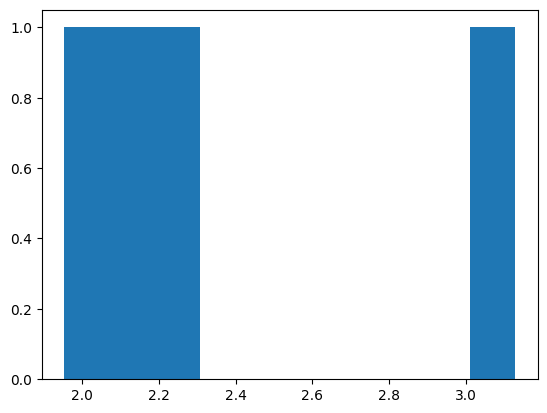

In [15]:
params = np.array(seq.values).squeeze()
plt.hist(params);

Next we need to define the summary statistics to be extracted from the simulated time-series. Custom metrics can be defined and wrapped in the callable `parameters.Metric`. Here we use the pre-defined example `demo.BoldFCDForSBI` which computes bold signal from the provided time-average time series and a set of useful metrics such as variability of functional connectivity dynamics and others.

Executing the large number of simulations can take a long time, here we perform local parallel execution, see docs for distributed execution examples.

In [16]:
metrics = [BoldFCDForSBI(win_len=3)]
run_local(seq, metrics, backend=NbMPRBackend, checkpoint_dir='test_run', filename='results.npy')

2022-10-12 11:26:48,247 - INFO - tvb.simulator.noise - White noise configured with dt=0.005
2022-10-12 11:26:48,251 - ERROR - tvb.simulator.simulator - Bad Simulator.integrator.noise.nsig shape: (2, 1, 1)
2022-10-12 11:26:48,253 - INFO - tvb.simulator.history - history has n_time=1 n_cvar=2 n_node=100 n_nmode=1, requires 0.60 MB
2022-10-12 11:26:48,253 - INFO - tvb.simulator.history - sparse history has n_nnzw=9146, i.e. 91.46 % sparse
2022-10-12 11:26:48,306 - INFO - tvb.simulator.noise - White noise configured with dt=0.005
2022-10-12 11:26:48,307 - ERROR - tvb.simulator.simulator - Bad Simulator.integrator.noise.nsig shape: (2, 1, 1)
2022-10-12 11:26:48,307 - INFO - tvb.simulator.noise - White noise configured with dt=0.005
2022-10-12 11:26:48,308 - ERROR - tvb.simulator.simulator - Bad Simulator.integrator.noise.nsig shape: (2, 1, 1)
2022-10-12 11:26:48,309 - INFO - tvb.simulator.history - history has n_time=1 n_cvar=2 n_node=100 n_nmode=1, requires 0.60 MB
2022-10-12 11:26:48,309 

In [17]:
estimator = EstimatorSBI(prior, seq, metrics)

In [18]:
summ_stats = estimator.load_summary_stats('results.npy')
summ_stats

,HOMO_FC,FCD_STACK_STD_INTER_TENS,FCD_SUBJ_DIFF_VAR_OV_TENS
0,0.691809,0.383053,0.037468
1,0.637510,0.395431,0.039941
2,0.671735,0.389102,0.040887
3,0.902859,0.404654,0.038128


In [19]:
posterior = estimator.train(summ_stats.values)

/home/izaak/local_repos/nostromo/tvb-inversion/env/lib/python3.8/site-packages/sbi/neural_nets/flow.py:108: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  warn(f"In one-dimensional output space, this flow is limited to Gaussians")


Neural network successfully converged after 123 epochs.


In [20]:
print(posterior)

Posterior conditional density p(θ|x) (amortized).

This DirectPosterior-object was obtained with a SNPE-class method using a flow.
It allows to .sample() and .log_prob() the posterior and wraps the output of the .net to avoid leakage into regions with 0 prior probability.


Let's now generate an empirical observable 

In [21]:
seq = prior.generate_sim_seq(sim, 1) # "empirical" data

run_local(seq, metrics, backend=NbMPRBackend, filename='results_empirical.npy')

summ_stats_empirical = estimator.load_summary_stats('results_empirical.npy')
summ_stats_empirical

  ERROR  Bad Simulator.integrator.noise.nsig shape: (2, 1, 1)
2022-10-12 11:29:48,374 - INFO - tvb.simulator.noise - White noise configured with dt=0.005
2022-10-12 11:29:48,374 - ERROR - tvb.simulator.simulator - Bad Simulator.integrator.noise.nsig shape: (2, 1, 1)
2022-10-12 11:29:48,375 - INFO - tvb.simulator.history - history has n_time=1 n_cvar=2 n_node=100 n_nmode=1, requires 0.60 MB
2022-10-12 11:29:48,376 - INFO - tvb.simulator.history - sparse history has n_nnzw=9146, i.e. 91.46 % sparse


,HOMO_FC,FCD_STACK_STD_INTER_TENS,FCD_SUBJ_DIFF_VAR_OV_TENS
0,0.803876,0.383541,0.034001


In [22]:
posterior_samples = posterior.sample((100,),torch.as_tensor(summ_stats_empirical.to_numpy()))

Drawing 100 posterior samples: 3217it [00:00, 71063.69it/s]                                                            


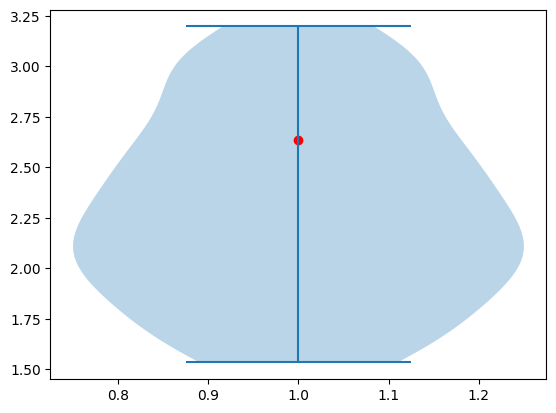

In [32]:
plt.violinplot(posterior_samples.numpy());
plt.scatter(1.,seq.values[0][0], c='r')